In [1]:
from quantum_error_correction_code import SurfaceCode, deformation_cmap
from neural_network import CNNDual, load_params

from environment import EnvironmentLookup

import jax.numpy as jnp
from jax import random
from time import time
import matplotlib.pyplot as plt

key = random.key(32)

In [2]:
settings, model_params = load_params("data/general_distance3_decoder.json")
print(settings.keys())

CODE_DISTANCE = settings["CODE_DISTANCE"]
print(f"{CODE_DISTANCE = }")

DEFORMATION_OPTIONS = settings["DEFORMATION_OPTIONS"]
print(f"{DEFORMATION_OPTIONS = }")

ERROR_PROBS = settings["ERROR_PROBS"]
print(f"{ERROR_PROBS = }")

CONV_LAYERS_INPUT_1 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_1"]]
print(f"{CONV_LAYERS_INPUT_1 = }")

CONV_LAYERS_INPUT_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_2"]]
print(f"{CONV_LAYERS_INPUT_2 = }")

CONV_LAYERS_STAGE_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_STAGE_2"]]
print(f"{CONV_LAYERS_STAGE_2 = }")

FC_LAYERS = settings["FC_LAYERS"].tolist()
print(f"{FC_LAYERS = }")

CODE_DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)

dict_keys(['CODE_DISTANCE', 'DEFORMATION_OPTIONS', 'ERROR_PROBS', 'CONV_LAYERS_INPUT_1', 'CONV_LAYERS_INPUT_2', 'CONV_LAYERS_STAGE_2', 'FC_LAYERS'])
CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 1, 2, 3, 4, 5], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS_INPUT_1 = [(8, 2, 1, 0)]
CONV_LAYERS_INPUT_2 = [(8, 1, 1, 0)]
CONV_LAYERS_STAGE_2 = [(8, 2, 1, 0)]
FC_LAYERS = [50, 2]


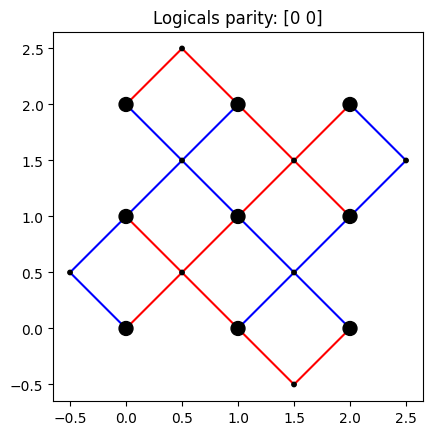

In [3]:
code = SurfaceCode(CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
code.show(parity_info)

In [4]:
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(6, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [5]:
all_logical_error_rates = jnp.load("data/environmentNoiselessCNN_error_rates_p01_nu500_halve.npy")
equivalence_mapper = lambda d: jnp.array([0,0,2,3,3,2])[d]
env = EnvironmentLookup(
    lookup_table=all_logical_error_rates,
    num_of_deformations=3,
    code=code,
    equivalence_mapper=equivalence_mapper
)

In [6]:
env._state_score(key, jnp.array([3, 2, 1, 2, 2, 3, 2, 0, 2]))[0] # = 401.46786 (optimal result)

Array(26.9826, dtype=float32)

In [7]:
state, score, key = env.reset(key)
score

Array(5.8133507, dtype=float32)

In [8]:
time_limit = 10
sample_count = 0
t0 = time()
while time() - t0 < time_limit:
    state, score, key = env.reset(key)
    sample_count = sample_count + 1
print(f"Average execution time = {(time()-t0)/sample_count:.3f}s per noiseless estimate ({sample_count} samples)")

Average execution time = 0.000s per noiseless estimate (79694 samples)


In [9]:
scores = []
for i in range(100):
    state, score, key = env.reset(key)
    scores.append(score)

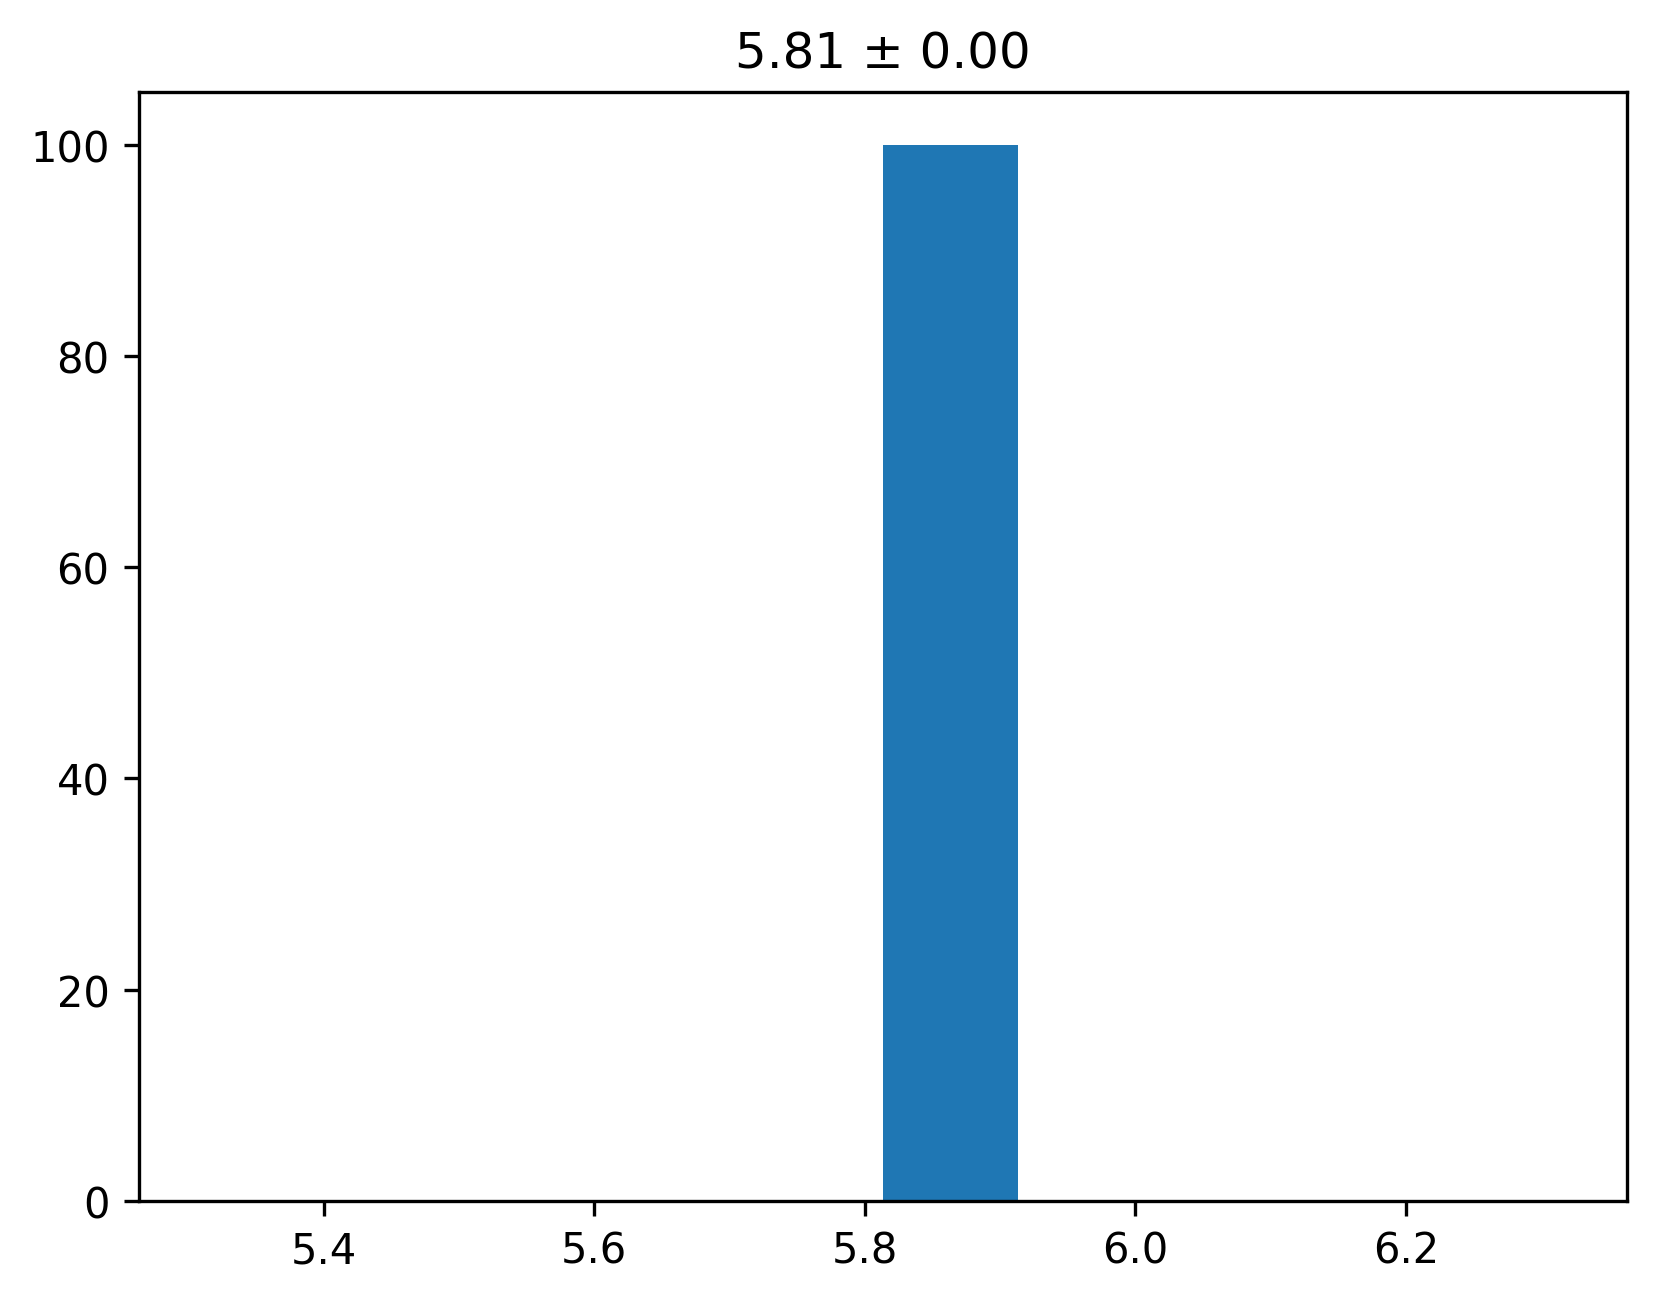

In [10]:
import matplotlib.pyplot as plt

x = jnp.array(scores)

plt.figure(dpi=300)
plt.title(f"{x.mean():.2f} ± {x.std():.2f}")
plt.hist(x)
plt.show()

# Make graph

In [11]:
deformations_included = jnp.array([0,2,3])
m = deformations_included.shape[0] # Number of diferent deformations per qubit
n = code.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = deformations_included[all_deformations]
print(all_deformations.shape)
print(all_deformations)

(19683, 9)
[[0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [0 3 3 ... 3 3 3]
 [2 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


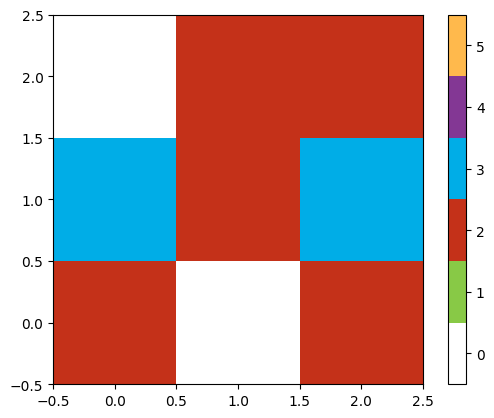

In [12]:
optimal_deformation = all_deformations[all_logical_error_rates.argmin()]

plt.figure()
plt.imshow(optimal_deformation.reshape(3,3), origin='lower', cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.colorbar()
plt.show()

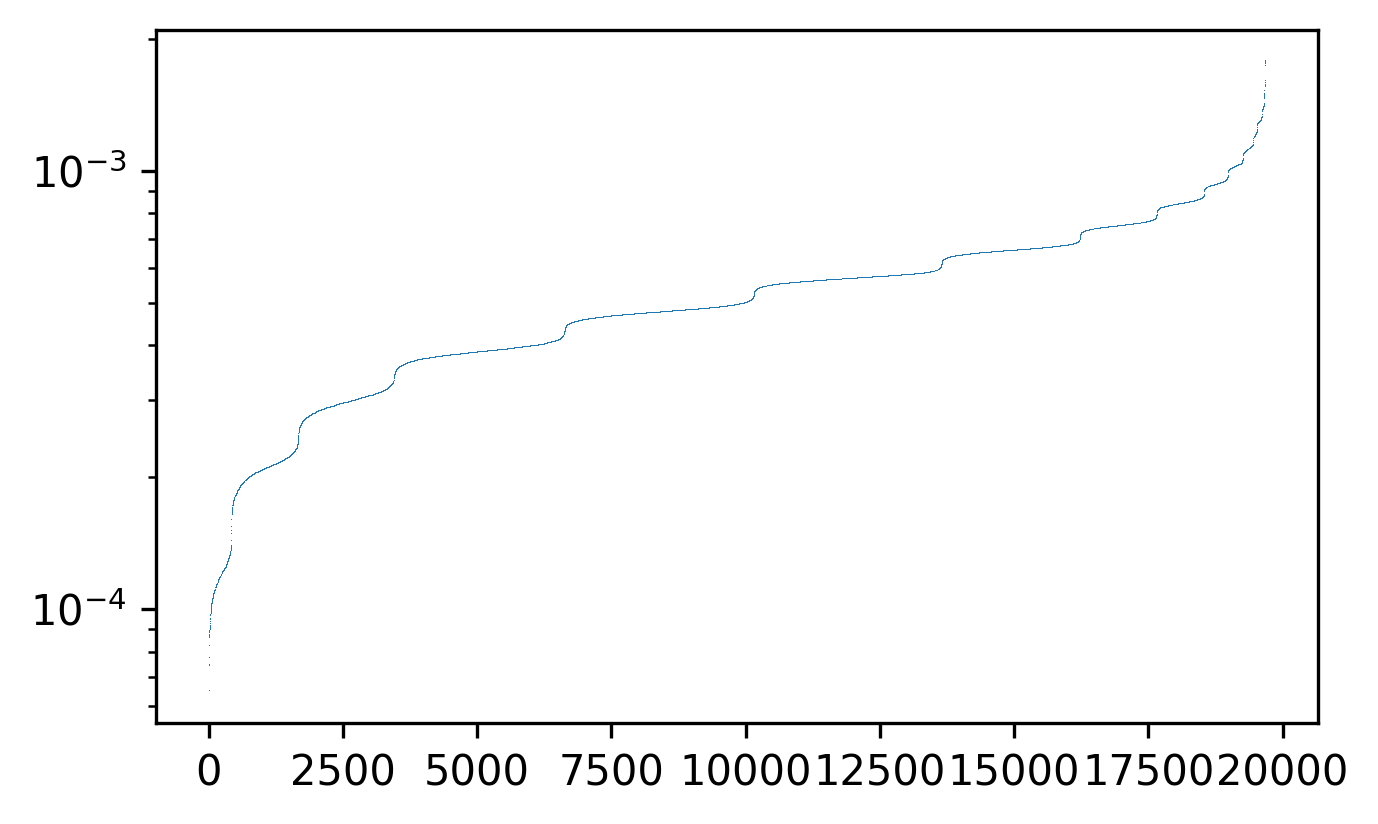

In [14]:
plt.figure(dpi=300, figsize=(5,3))
plt.plot(all_logical_error_rates.sort(), ',')
plt.yscale('log')
plt.show()